## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# https://www.hostinger.com.ar/tutoriales/usar-comando-wget/#Usando-el-comando-Wget-para-descargar-archivos-individuales
!wget -P ../data/raw https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-17 18:47:25--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 7077973 (6,8M) [text/plain]
Guardando como: “../data/raw/AB_NYC_2019.csv.2”

AB_NYC_2019.csv.2   100%[===================>]   6,75M  11,9MB/s    en 0,6s    

2021-10-17 18:47:26 (11,9 MB/s) - “../data/raw/AB_NYC_2019.csv.2” guardado [7077973/7077973]



In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('../data/raw/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

df.price = np.log1p(df.price)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [6]:
from sklearn.feature_extraction import DictVectorizer

def prepare(X, dv = None):
    
    dicts = X.to_dict(orient='records')
    
    if dv is None:
        dv = DictVectorizer(sparse=False)
        dv.fit(dicts)
    
    return dv.transform(dicts), dv
    
def select_columns(data):
    return data.loc[:, ~data.columns.isin(["price"])], data[['price']].values

X_train, y_train = select_columns(df_train)
X_train, dv = prepare(X_train)

X_val, y_val = select_columns(df_val)
X_val, _ = prepare(X_val, dv)

X_test, y_test = select_columns(df_test)
X_test, _ = prepare(X_test, dv)

assert X_train.shape[1] == X_val.shape[1]
assert X_train.shape[1] == X_test.shape[1]

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [8]:
model = DecisionTreeRegressor(max_depth=1, random_state=1)

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [9]:
print(export_text(model, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Answer 1: room_type

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from functools import partial

rmse = partial(mean_squared_error, squared=True)

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=2)

rf.fit(X_train, y_train)

/tmp/ipykernel_5446/1400226127.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=2, random_state=1)

In [12]:
y_pred = rf.predict(X_val)
rmse(y_val, y_pred), rmse(y_train, rf.predict(X_train))

(0.21146531304697053, 0.03961064360842908)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Answer 2: 0.21 near by 0.259

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [28]:
scores = []
models = []
before_score = 0

for n_estimators in range(10, 201,10):
    m = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=2)
    m.fit(X_train, y_train)
    score_train = rmse(y_train, m.predict(X_train))
    score_val = rmse(y_val, m.predict(X_val))
    scores.append([n_estimators, score_train, score_val])
    print(n_estimators, " ==> (train)-(val)" ,score_train, score_val)
    models.append(m)
    
    # early_stopping
    if -0.00001 <= round(score_val - before_score, 5) <= 0.00001 :
        break
    else:
        before_score = score_val


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


10  ==> (train)-(val) 0.03961064360842908 0.21146531304697053


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


20  ==> (train)-(val) 0.03334020999253188 0.20055280740715697


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


30  ==> (train)-(val) 0.03127353797435545 0.19813184542039794


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


40  ==> (train)-(val) 0.030388501031102518 0.19644875942998385


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


50  ==> (train)-(val) 0.029736302757359126 0.19556817187772324


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


60  ==> (train)-(val) 0.02934172507948818 0.1949529684982942


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


70  ==> (train)-(val) 0.028915581169468182 0.19436327898011693


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


80  ==> (train)-(val) 0.02870722163617675 0.19427170579043732


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


90  ==> (train)-(val) 0.028484892764328217 0.19381449981090235


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


100  ==> (train)-(val) 0.028302786332540786 0.19340892199055484


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


110  ==> (train)-(val) 0.02818780766022375 0.19300937948732258


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


120  ==> (train)-(val) 0.02803918465741807 0.19284402829346295


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


130  ==> (train)-(val) 0.027908301435213816 0.19294942636331303


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


140  ==> (train)-(val) 0.027767848121006893 0.19281479697514123


/tmp/ipykernel_5446/2798036239.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


150  ==> (train)-(val) 0.027695323151458305 0.19280774684445923


In [29]:
scores = pd.DataFrame.from_records(scores)
scores.columns = ['n_estimators', 'rmse_train', 'rmse_val']

In [30]:
points = [10,50,70,120]

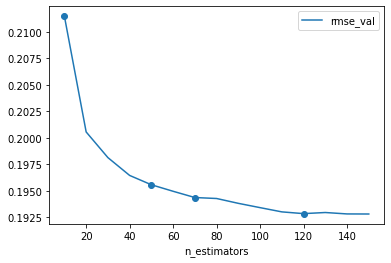

In [32]:
scores.plot.line(x='n_estimators', y='rmse_val')
plt.scatter(points, scores.rmse_val[scores.n_estimators.isin(points)])

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

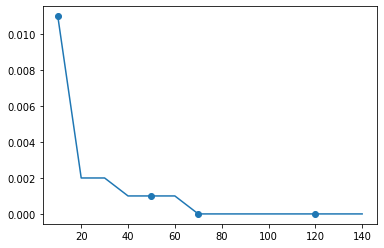

In [33]:
plt.plot(scores.n_estimators, round(scores.rmse_val - scores.shift(-1).rmse_val, 3))
plt.scatter(points, round(scores.rmse_val - scores.shift(-1).rmse_val, 3)[scores.n_estimators.isin(points)])

Answer 3: 70

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [72]:
scores_4 = []
models_4 = []

for max_depth in [10, 15, 20, 25]:
    before_score = 0
    for n_estimators in range(10, 201,10):
        m = RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            random_state=1, 
            n_jobs=2, 
            verbose=0
        )
        m.fit(X_train, y_train)
        score_train = rmse(y_train, m.predict(X_train))
        score_val = rmse(y_val, m.predict(X_val))
        scores_4.append([n_estimators, max_depth, score_train, score_val])
        print(n_estimators, max_depth, " ==> (train)-(val)" ,score_train, score_val)
        models_4.append(m)

        # early stopping
        if -1e-5 <= round(score_val - before_score, 5) <= 1e-5 :
            print("BREAK")
            break
        else:
            before_score = score_val

/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


10 10  ==> (train)-(val) 0.15802221706484654 0.19855594827760942


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


20 10  ==> (train)-(val) 0.1551879629956624 0.19539302028332006


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


30 10  ==> (train)-(val) 0.1543010919018198 0.19482695224078175


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


40 10  ==> (train)-(val) 0.15397280896320226 0.1949580450431018


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


50 10  ==> (train)-(val) 0.15380853763769167 0.1945872126630386


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


60 10  ==> (train)-(val) 0.15360000820333958 0.1945653952080406


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


70 10  ==> (train)-(val) 0.15361273390001584 0.19430883384749043


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


80 10  ==> (train)-(val) 0.153527631576786 0.19415825501133632


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


90 10  ==> (train)-(val) 0.15355651149439722 0.19391698060590218


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


100 10  ==> (train)-(val) 0.1535993685996907 0.19372665062480296


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


110 10  ==> (train)-(val) 0.15355516013132584 0.1936473188625389


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


120 10  ==> (train)-(val) 0.15340967325143345 0.19345944394031528


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


130 10  ==> (train)-(val) 0.15332937115063708 0.19348946201946043


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


140 10  ==> (train)-(val) 0.15327028468131773 0.1934822996379859
BREAK


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


10 15  ==> (train)-(val) 0.08590330028694594 0.20233582707904535


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


20 15  ==> (train)-(val) 0.08095095409389054 0.1943083151477615


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


30 15  ==> (train)-(val) 0.07922736264238987 0.1931074697644532


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


40 15  ==> (train)-(val) 0.07884913253089496 0.19253836870698748


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


50 15  ==> (train)-(val) 0.07856668274911228 0.19193899473266296


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


60 15  ==> (train)-(val) 0.07815613397018678 0.19163160907501378


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


70 15  ==> (train)-(val) 0.07799770965222413 0.19130566813748742


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


80 15  ==> (train)-(val) 0.07794171707198526 0.19120372944045674


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


90 15  ==> (train)-(val) 0.07781230136500922 0.19085577497386869


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


100 15  ==> (train)-(val) 0.07763277186482703 0.1905703272688817


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


110 15  ==> (train)-(val) 0.07759361027253145 0.19034686551292174


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


120 15  ==> (train)-(val) 0.07737052702217169 0.19029859311311223


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


130 15  ==> (train)-(val) 0.07723494915785956 0.19038257509203824


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


140 15  ==> (train)-(val) 0.07703456220424218 0.19030933653731494


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


150 15  ==> (train)-(val) 0.07692860895815426 0.19034206423324893


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


160 15  ==> (train)-(val) 0.07674148145785661 0.19018170701315204


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


170 15  ==> (train)-(val) 0.07673818341217326 0.1900861261996287


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


180 15  ==> (train)-(val) 0.07679679460967649 0.1902023537808285


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


190 15  ==> (train)-(val) 0.07680227949150507 0.19021262734828198
BREAK


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


10 20  ==> (train)-(val) 0.04972114768058459 0.2113832907646296


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


20 20  ==> (train)-(val) 0.04375586420992404 0.19963594574455046


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


30 20  ==> (train)-(val) 0.04170473189581527 0.19722571252889412


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


40 20  ==> (train)-(val) 0.04109704463550683 0.19568051866689343


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


50 20  ==> (train)-(val) 0.04066507667110717 0.19475956696393812


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


60 20  ==> (train)-(val) 0.040235480442659184 0.1940884979052719


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


70 20  ==> (train)-(val) 0.039895776454198485 0.19359887720586214


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


80 20  ==> (train)-(val) 0.039743592950342965 0.19354058102681332


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


90 20  ==> (train)-(val) 0.039533899864564376 0.19298319022375787


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


100 20  ==> (train)-(val) 0.039335229229549656 0.19254866852579725


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


110 20  ==> (train)-(val) 0.03920629292903429 0.192163775239227


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


120 20  ==> (train)-(val) 0.039051471161334596 0.19205278711369492


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


130 20  ==> (train)-(val) 0.03888959105533107 0.19209324454827456


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


140 20  ==> (train)-(val) 0.03868196675293927 0.19189346196713408


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


150 20  ==> (train)-(val) 0.03859843177879217 0.19184241458749732


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


160 20  ==> (train)-(val) 0.03843120190667306 0.19166643719581122


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


170 20  ==> (train)-(val) 0.03839845976781597 0.19153267322757475


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


180 20  ==> (train)-(val) 0.038395557478082654 0.19158627145279306


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


190 20  ==> (train)-(val) 0.038371505425659216 0.19153754932581943


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


200 20  ==> (train)-(val) 0.038332013655904426 0.1915337099788796
BREAK


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


10 25  ==> (train)-(val) 0.040951301750328246 0.2122445346370779


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


20 25  ==> (train)-(val) 0.034778424233416975 0.20063516400364267


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


30 25  ==> (train)-(val) 0.03264327999239313 0.19796780995316868


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


40 25  ==> (train)-(val) 0.031878259670508176 0.19642999161258673


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


50 25  ==> (train)-(val) 0.03126771088293465 0.19576807181918765


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


60 25  ==> (train)-(val) 0.030844615938998513 0.1951899515103211


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


70 25  ==> (train)-(val) 0.0304524607099061 0.194686327033654


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


80 25  ==> (train)-(val) 0.030263996203444523 0.19459989124043695


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


90 25  ==> (train)-(val) 0.030014534898339922 0.19407835058320705


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


100 25  ==> (train)-(val) 0.029836217344671397 0.19378894645057607


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


110 25  ==> (train)-(val) 0.029717386022591972 0.1932651540780089


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


120 25  ==> (train)-(val) 0.029564051813114972 0.1930463031980234


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


130 25  ==> (train)-(val) 0.02942818789698371 0.1931709041621106


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


140 25  ==> (train)-(val) 0.029278215713169273 0.19295300183376413


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


150 25  ==> (train)-(val) 0.02920159743486906 0.19289453238956553


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


160 25  ==> (train)-(val) 0.029080085487911512 0.19278213852886114


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


170 25  ==> (train)-(val) 0.029030726548679612 0.19264852755553047


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


180 25  ==> (train)-(val) 0.02901829136312845 0.19279277654436075


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


190 25  ==> (train)-(val) 0.028998558644631762 0.19269747345290747


/tmp/ipykernel_5446/3142257607.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


200 25  ==> (train)-(val) 0.028957210074514367 0.19268877839175813
BREAK


In [76]:
scores_4 = pd.DataFrame.from_records(scores_4)
scores_4.columns = ['n_estimators', 'max_depth', 'rmse_train', 'rmse_val']


In [77]:
scores_4.groupby('max_depth').agg(
    {
        'rmse_train':['mean', 'std'],
        'rmse_val':['mean', 'std'],
        'n_estimators':['count']
    }
    )

rmse_train            rmse_val           n_estimators
                mean       std      mean       std        count
max_depth                                                      
10          0.154054  0.001243  0.194505  0.001317           14
15          0.078225  0.002137  0.191693  0.002826           19
20          0.040102  0.002648  0.194167  0.004589           20
25          0.030760  0.002819  0.195216  0.004513           20

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

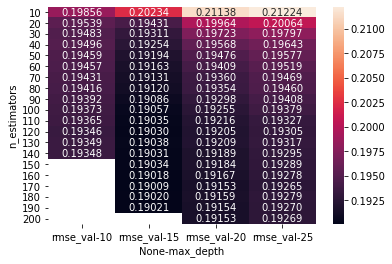

In [78]:
sns.heatmap(data=scores_4.iloc[:, [0,1,3]].pivot(index='n_estimators', columns='max_depth'), annot=True, fmt=".5f")

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Answer 4: 15

why? the mean of max_depth=15 is the lowest of them



Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [56]:
params = {
    'n_estimators':10,
    'max_depth': 20,
    'random_state': 1,
    'n_jobs': 3
}

model_5 = RandomForestRegressor(**params)

In [57]:
model_5.fit(X_train, y_train)

/tmp/ipykernel_5446/3251605712.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_5.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=3, random_state=1)

Text(0.5, 1.0, 'Top 15 important features')

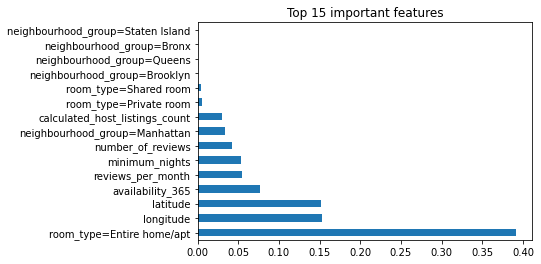

In [58]:
feat_importances = pd.Series(model_5.feature_importances_, index=dv.get_feature_names())
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`



Answer 5 : `room_type=Entire home/apt`	

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [59]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 76 kB/s 


In [60]:
import xgboost as xgb

In [64]:
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [65]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [70]:
# %%capture output

scores_xgb = []
for eta in [0.3, 0.1, 0.01]:
    m = xgb.train({ **xgb_params, "eta": eta}, 
        dtrain, 
        #verbose_eval=5,
        num_boost_round=100,
        evals = [(dtrain, 'train'), (dval, 'val')]
    )
    score_train = rmse(y_train, m.predict(dtrain))
    score_val = rmse(y_val, m.predict(dval))
    scores_xgb.append([eta, score_train, score_val])
    print(eta, " ==> (train)-(val)", score_train, score_val)


[0]	train-rmse:3.02752	val-rmse:3.02415
[1]	train-rmse:2.14667	val-rmse:2.14390
[2]	train-rmse:1.53878	val-rmse:1.53721
[3]	train-rmse:1.12557	val-rmse:1.12523
[4]	train-rmse:0.85100	val-rmse:0.85174
[5]	train-rmse:0.67490	val-rmse:0.67752
[6]	train-rmse:0.56687	val-rmse:0.57148
[7]	train-rmse:0.50448	val-rmse:0.51139
[8]	train-rmse:0.46913	val-rmse:0.47777
[9]	train-rmse:0.45009	val-rmse:0.45965
[10]	train-rmse:0.43912	val-rmse:0.44981
[11]	train-rmse:0.43327	val-rmse:0.44475
[12]	train-rmse:0.42936	val-rmse:0.44210
[13]	train-rmse:0.42668	val-rmse:0.44038
[14]	train-rmse:0.42463	val-rmse:0.43943
[15]	train-rmse:0.42259	val-rmse:0.43827
[16]	train-rmse:0.42113	val-rmse:0.43772
[17]	train-rmse:0.42074	val-rmse:0.43787
[18]	train-rmse:0.41896	val-rmse:0.43744
[19]	train-rmse:0.41812	val-rmse:0.43726
[20]	train-rmse:0.41716	val-rmse:0.43691
[21]	train-rmse:0.41499	val-rmse:0.43645
[22]	train-rmse:0.41437	val-rmse:0.43611
[23]	train-rmse:0.41403	val-rmse:0.43614
[24]	train-rmse:0.41391	va

Now change `eta` first to `0.1` and then to `0.01`

In [71]:
print(scores_xgb)

[[0.3, 0.13306406476714144, 0.1902794658815014], [0.1, 0.16222520683222824, 0.18705326790701157], [0.01, 2.663347181512667, 2.6583751556838666]]


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

Answer 6: 0.1

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

